In [1]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.gridspec import GridSpec
import numpy as np
import pandas as pd

import json

from glob import glob
import os

from importlib import reload

import utils
import persim
import itertools

from sklearn import manifold, cluster, preprocessing
import tifffile as tf
from KDEpy import FFTKDE
from scipy import ndimage,stats,spatial

In [2]:
nuclei_mask_cutoff = 1
seed = 42
ndims = 3
fs = 12
PP = 6
dpi = 96
minlife = 0.05

marker = ['D', '8', 's', '^', 'v', 'P', 'X', '*']
color = ['#56b4e9', '#f0e442', '#009e73', '#0072b2', '#d55e00', '#cc79a7', '#e69f00', '#e0e0e0', '#000000']
cmap = ['Blues_r', 'Wistia', 'Greens_r', 'BuPu_r', 'Oranges_r', 'RdPu_r']
box_params = {'widths':0.75, 'patch_artist':True, 'medianprops':{'lw':3, 'color':'red'} }
#figdst = os.path.expanduser('~') + '/documents/website/mcarto/figs/'
sample = 'D2'

wsrc = '../cell_dams/'
nsrc = '../nuclear_mask/'
tsrc = '../translocs/'
ksrc = '../kde/'
isrc = '..' + os.sep + 'infected_focus_summer24' + os.sep 

isrc += sample + os.sep
ksrc += sample + os.sep

metacell = pd.read_csv(ksrc + sample + '_cells_metadata.csv', index_col=0)
metatrans = pd.read_csv(ksrc + sample + '_transcripts_metadata.csv')
transcell = pd.read_csv(ksrc + sample + '_transcells_metadata.csv').set_index('gene')
weight = np.load(ksrc + sample + '_border_weights.npy', allow_pickle=True)
transcriptomes = np.asarray(list(metatrans['gene']))
metatrans = metatrans.set_index('gene')

Cells = utils.get_range_cell_values(isrc + 'infected_cells_ids.csv', metacell, startval=1)
Genes = utils.get_range_gene_values(isrc + 'genes_to_focus_infection.csv', transcriptomes, startval=0)
invGenes = dict(zip(Genes, range(len(Genes))))
invCells = dict(zip(Cells, range(len(Cells))))

transfocus = transcell.loc[transcriptomes[Genes], Cells.astype(str)]

wall = tf.imread(wsrc + sample + '_dams.tif').astype(bool)
label, cellnum = ndimage.label(wall, ndimage.generate_binary_structure(2,1))
css = ndimage.find_objects(label)
wall[tf.imread(nsrc + sample + '_EDT.tif') < nuclei_mask_cutoff] = False
wcoords = np.asarray(np.nonzero(~wall))
wallshape = wall.shape
wc = wcoords[:, ~np.all(wcoords%100, axis=0)]

translocs = [None for i in range(len(transcriptomes))]
for i in range(len(transcriptomes)):
    filename = tsrc + sample + os.sep + 'location_corrected_D2_-_' + transcriptomes[i] + '.csv'
    translocs[i] = pd.read_csv(filename, header=None, names=['X', 'Y', 'Z'])
tlocs = pd.concat(translocs)
tcumsum = np.hstack(([0], np.cumsum(metatrans['cyto_number'].values)))

handles = [None for _ in range(len(Genes))]
for i in range(len(handles)):
    handles[i] = mlines.Line2D([], [], mfc=color[i], marker=marker[i], ls='None', mec='k', mew=1, ms=7)

transfocus

,742,842,2052,1145,896,2152,558,751,746,236,...,303,1782,1724,1571,1583,1454,2430,1143,752,513
gene,,,,,,,,,,,,,,,,,,,,,
GLYMA_17G195900,363,1247,1026,572,938,1185,531,1819,984,1314,...,228,156,48,62,107,132,49,86,138,371
GLYMA_05G216000,5,17,15,26,17,32,20,15,11,23,...,3,0,0,1,4,1,0,2,4,7
GLYMA_17G185800,1,10,12,7,18,13,6,24,4,27,...,6,5,1,3,8,11,1,7,6,19
GLYMA_05G203100,0,0,1,2,0,0,0,0,1,2,...,8,0,0,0,0,0,0,2,0,1
GLYMA_15G210100,7,19,12,11,12,17,8,11,21,20,...,7,3,1,1,1,2,0,5,3,8
GLYMA_05G092200,249,317,582,307,195,1026,529,687,341,694,...,439,406,187,183,271,241,62,152,396,806


In [383]:
level = 'sub'
normtype = 'gene'
bw = 25
stepsize = 3
SCALE = 16

zmax = np.max(tlocs['Z']+stepsize)
zbins = np.arange(0, zmax+stepsize, stepsize)

dsrc = isrc + 'G{}_{}level_{}_step{}_bw{}'.format(len(Genes), level, normtype, stepsize, bw) + os.sep
ratios = utils.normalize_counts(transfocus, normtype)

jsonfiles = [ [ None for j in range(ratios.shape[1]) ] for i in range(ratios.shape[0]) ]
gsrc = '../{}level/'.format(level) + sample + os.sep
for i in range(len(jsonfiles)):
    foo = '{}{}/{}_-_{}_p{}_s{}_bw{}_c{:06d}.json'
    for j in range(len(jsonfiles[0])):
        filename = foo.format(gsrc, transcriptomes[Genes[i]],transcriptomes[Genes[i]],level,PP,stepsize,bw,Cells[j])
        if os.path.isfile(filename):
            jsonfiles[i][j] = filename

In [384]:
orig_diags = [ utils.get_diagrams(jsonfiles[i], ndims, remove_inf=True) for i in range(len(jsonfiles))]
orig_diags, rescale, maxlife, focus_dim = utils.normalize_persistence_diagrams(orig_diags, ratios, normtype, SCALE)
lt_mask = np.any(maxlife > minlife, axis=2)
gmask, cmask = np.nonzero(lt_mask)
uq , cts = np.unique(gmask, return_counts=True)
nzcumsum = np.hstack(([0], np.cumsum(cts) ))

if normtype == 'gene':
    diags = [ [ [ rescale[i][0][0]*orig_diags[i][j][k].copy() for k in range(len(orig_diags[i][j])) ] for j in range(len(orig_diags[i])) ] for i in range(len(orig_diags)) ]
elif normtype == 'both':
    diags = [ [ [ rescale*orig_diags[i][j][k].copy() for k in range(len(orig_diags[i][j])) ] for j in range(len(orig_diags[i])) ] for i in range(len(orig_diags)) ]
for i in range(len(diags)):
    for j in range(len(diags[i])):
        for k in range(len(diags[i][j])):
            diags[i][j][k] = np.atleast_2d(diags[i][j][k][ diags[i][j][k][:,1] - diags[i][j][k][:,0] > minlife, : ])

full_lt_coll = [ [None for _ in range(np.sum(lt_mask)) ] for _ in range(ndims) ]
for i in range(len(gmask)):
    for k in range(len(full_lt_coll)):
        d = diags[gmask[i]][cmask[i]][k]
        full_lt_coll[k][i] = np.column_stack( (d[:, 0], d[:, 1] - d[:, 0])  )

maxbirth = 0
for k in range(len(full_lt_coll)):
    for i in range(len(full_lt_coll[k])):
        if len(full_lt_coll[k][i]) > 0:
            b = np.max(full_lt_coll[k][i][:,0])
            if b > maxbirth:
                maxbirth = b

Initial number of life-birth pairs	: 145313

No. of diagrams s.t. H_k had the most persistent component
H_0:	775 [ 13.3% ]
H_1:	509 [ 8.8% ]
H_2:	4524 [ 77.9% ]

Will focus just on dimension k = 2



# Bring in persistence images to the party

In [385]:
sigma = 1
pers_w = 1
pixel_size = 1

pi_params = {'birth_range':(0,min([SCALE, int(np.ceil(maxbirth + sigma))] )),
             'pers_range':(0,min([SCALE, int(np.ceil(maxlife[:,:,focus_dim].max()+sigma))])),
             'pixel_size': pixel_size,
             'weight': 'persistence',
             'weight_params': {'n': pers_w},
             'kernel':'gaussian',
             'kernel_params':{'sigma': [[sigma, 0.0], [0.0, sigma]]} }
                       
pimgr = persim.PersistenceImager(**pi_params)
extent = np.array([ pimgr.birth_range[0], pimgr.birth_range[1], pimgr.pers_range[0], pimgr.pers_range[1] ]).astype(int)
full_img = np.zeros((len(full_lt_coll), len(full_lt_coll[0]), extent[1], extent[3]))
for k in range(len(full_img)):
    full_img[k] = np.asarray(pimgr.transform(full_lt_coll[k], skew=False))
full_img[full_img < 0] = 0

In [564]:
method = 'PCA'
hdims = np.array([1,2])
Pname = ' [$' + ' \\oplus '.join(['H_{}'.format(k) for k in hdims]) + '$]'
pname = 'H' + '+'.join(hdims.astype(str))
csvfilename = dsrc + 'scale{}_-_PI_{}_{}_{}_pca_{}.csv'.format(SCALE, sigma, pers_w, pixel_size, pname )
print(csvfilename)
embedding = pd.read_csv(csvfilename)
pca = embedding.iloc[:,2:4].values
foo = [bw, stepsize, level.title(), normtype.title(), sigma, pers_w]
Bname = 'KDE bandwidth {}, stepsize {}. {}level persistence. {} normalized. PIs $\sigma = {}$. Weighted by $n^{{{}}}$.'.format(*foo)
bname = 'scale{}_-_PI_{}_{}_{}_'.format(SCALE, sigma, pers_w, pixel_size)

../infected_focus_summer24/D2/G6_sublevel_gene_step3_bw25/scale16_-_PI_1_1_1_pca_H1+2.csv


In [575]:
steps = 0.75
llim = int(np.floor(pca[:,0].min()))
rlim = int(np.ceil(pca[:,0].max()))

blim = int(np.floor(pca[:,1].min()))
tlim = int(np.ceil(pca[:,1].max()))
print(llim, tlim, rlim, blim)

yaxis = np.linspace(blim, tlim, int(steps*(tlim - blim))+1)[::-1]
xaxis = np.linspace(llim, rlim, int(steps*(rlim - llim))+1)
AXES = np.meshgrid(yaxis, xaxis, indexing='ij')
grid = np.column_stack([ np.ravel(AXES[i]) for i in range(len(AXES)) ])

dists = spatial.distance.cdist(np.flip(grid, axis=1), pca, metric='euclidean')
mindist = np.min(dists, axis=1)
minmask = mindist < 1/(4*steps)

blim, llim = np.min(grid[minmask], axis=0)
tlim, rlim = np.max(grid[minmask], axis=0)
print(llim, tlim, rlim, blim)

yaxis = np.linspace(blim, tlim, int(steps*(tlim - blim))+1)[::-1]
xaxis = np.linspace(llim, rlim, int(steps*(rlim - llim))+1)
AXES = np.meshgrid(yaxis, xaxis, indexing='ij')
grid = np.column_stack([ np.ravel(AXES[i]) for i in range(len(AXES)) ])

dists = spatial.distance.cdist(np.flip(grid, axis=1), pca, metric='euclidean')
argmin = np.argmin(dists, axis=1)
mindist = np.min(dists, axis=1)
minmask = mindist < 1/(4*steps)
reps = argmin[minmask]

-2 5 7 -5
-0.5 3.571428571428571 5.5 -2.142857142857143


In [576]:
lt_coll = [None for _ in range(len(reps))]
for i in range(len(lt_coll)):
    foo = [full_lt_coll[k][reps[i]].copy() for k in hdims]
    for j in range(1, len(hdims)):
        foo[j][:,0] += j*full_img.shape[2]
    lt_coll[i] = np.vstack(foo)
    
img = np.hstack(full_img[hdims])[reps]
vmax = np.quantile(img[img > 0], 0.99)
nrow = int((tlim - blim)*steps)+1
ncol = int((rlim - llim)*steps)+1

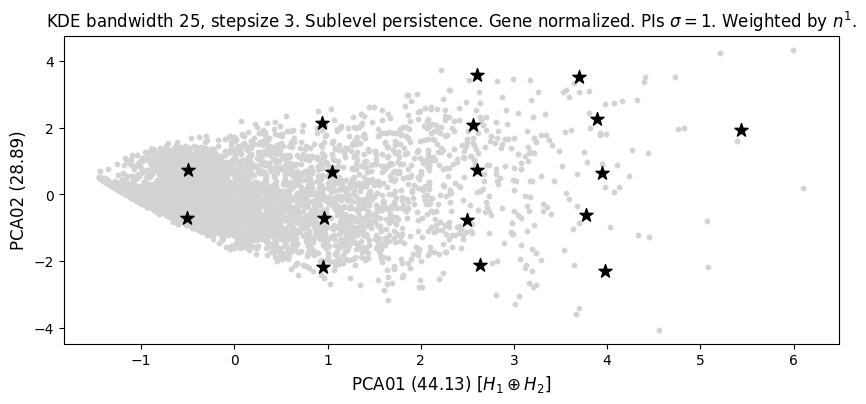

In [577]:
fig, ax = plt.subplots( 1,1, figsize=(10, 4), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel(); i = 0

ax[i].set_title(Bname, fontsize=fs)
ax[i].scatter(pca[:,0], pca[:,1], c='lightgray', marker='o', s=10, alpha=1, zorder=1)
ax[i].scatter(pca[reps,0], pca[reps,1], c='k', marker='*', s=100, alpha=1, zorder=2)
ax[i].set_xlabel(embedding.columns[2]+Pname, fontsize=fs)
ax[i].set_ylabel(embedding.columns[3], fontsize=fs)
filename = dsrc + bname + method.lower() + '_' + pname + '_gridded'
plt.savefig(filename + '.png', dpi=dpi, bbox_inches='tight', format='png')

../infected_focus_summer24/D2/G6_sublevel_gene_step3_bw25/scale16_-_PI_1_1_1_pca_H1+2_PI_sample


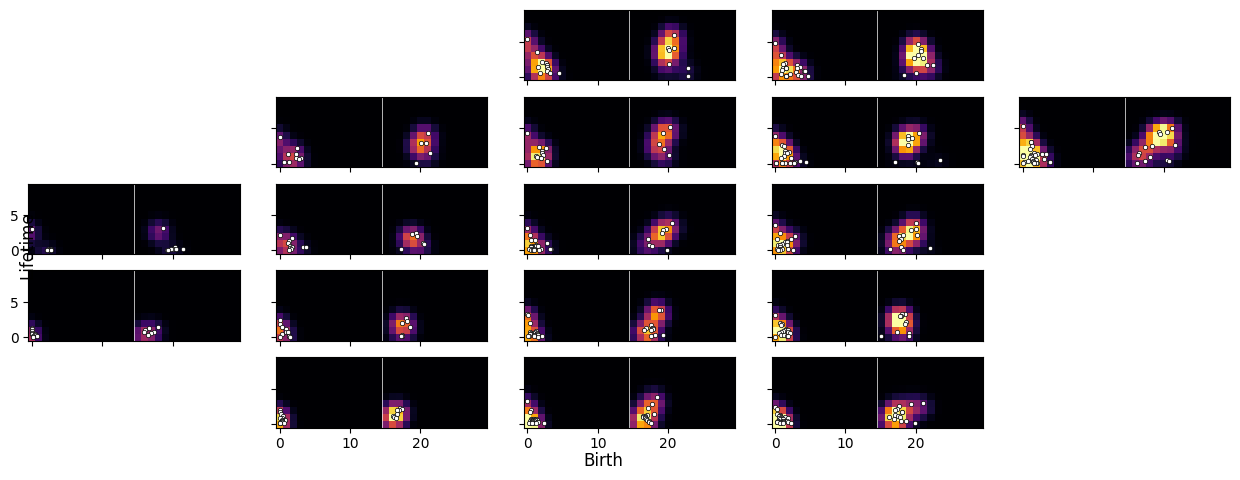

In [580]:
fig, ax = plt.subplots( nrow, ncol, figsize=(13, (0+0.5*len(hdims))*nrow), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel();

for i, j in enumerate(np.nonzero(minmask)[0]):
    ax[j].imshow(img[i].T, cmap='inferno', vmin=0, vmax=vmax, origin='lower')
    for k in range(1, len(hdims)):
        ax[j].axvline(k*full_img.shape[2] - .5, c='white', lw=0.5)
    ax[j].scatter(lt_coll[i][:,0], lt_coll[i][:,1], c='w', marker='o', s=10, edgecolor='k', linewidth=0.5)

foo = np.nonzero(~minmask)[0]
if len(foo) > 0:
    for j in foo:
        fig.delaxes(ax[j])

fig.supxlabel('Birth', fontsize=fs, y=0.05)
fig.supylabel('Lifetime', fontsize=fs, x=0.05)
fig.tight_layout();
filename = dsrc + bname + method.lower() + '_' + pname + '_PI_sample'
print(filename)
plt.savefig(filename + '.png', dpi=dpi, bbox_inches='tight', format='png')

In [581]:
KDE = [None for _ in range(len(reps))]
hcells = [None for _ in range(len(reps))]
hcoords = [None for _ in range(len(reps))]
hextent = [None for _ in range(len(reps))]
hzhist = [None for _ in range(len(reps))]

for i in range(len(KDE)):
    cidx = embedding.loc[reps[i], 'ndimage_ID']
    cell, cextent = utils.get_cell_img(cidx, metacell, wall, label, pxbar=False)
    axes, grid, gmask, cgrid, cgridmask = utils.cell_grid_preparation(cell, cextent, zmax, stepsize)
    cmask = label[ translocs[ embedding.loc[reps[i], 'gene_ID']]['Y'], translocs[embedding.loc[reps[i], 'gene_ID']]['X'] ] == cidx
    coords = translocs[embedding.loc[reps[i], 'gene_ID']].iloc[cmask].values.T
    zhist, _ = np.histogram(coords[2], bins=zbins, density=True)
    
    w = weight[tcumsum[embedding.loc[reps[i], 'gene_ID']] : tcumsum[embedding.loc[reps[i], 'gene_ID']+1]][cmask]
    kde = FFTKDE(kernel='gaussian', bw=bw, norm=2).fit(coords.T, w).evaluate(grid)
    kde = kde[gmask]/( np.sum(kde[gmask]) * (stepsize**len(coords)) )
    kde[ cgridmask ] = 0
    kde = kde/( np.sum(kde) * (stepsize**len(coords)) )
    
    KDE[i] = kde.reshape( list(map(len, axes))[::-1], order='F')
    hcells[i] = cell
    hextent[i] = cextent
    hcoords[i] = coords
    hzhist[i] = zhist

pxs = 75
pxbar = np.s_[-25:-5, 5:5 + pxs]
for cell in hcells:
    cell[pxbar] = 0

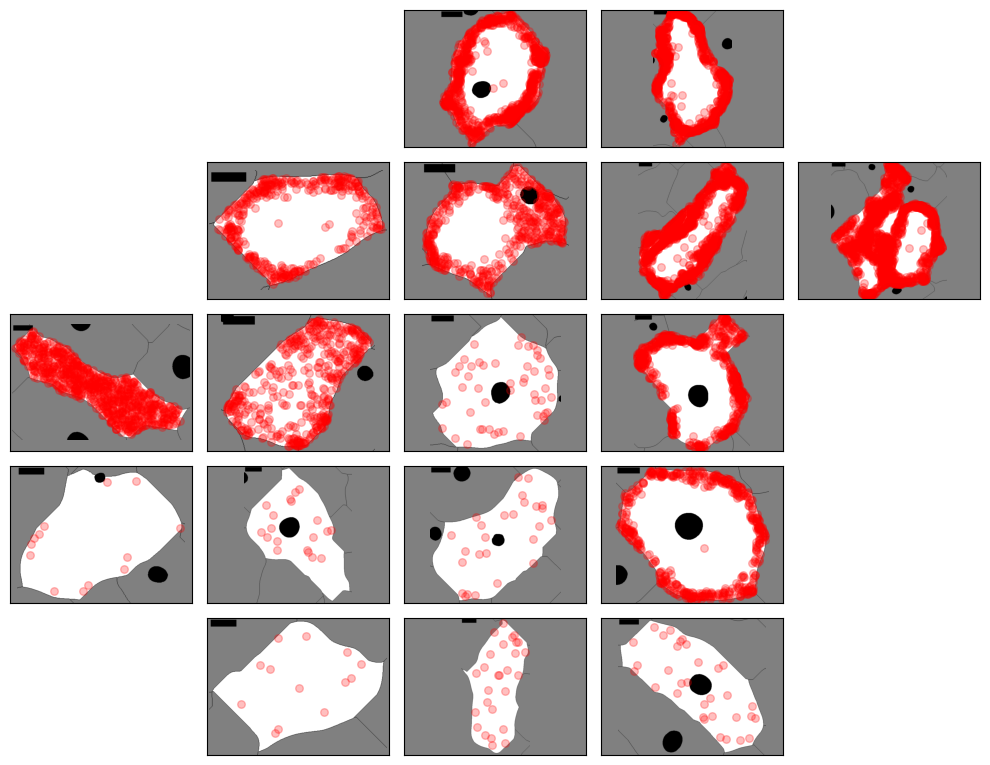

In [582]:
fig, ax = plt.subplots( nrow, ncol, figsize=(10, 1.55*nrow), sharex=False, sharey=False)
ax = np.atleast_1d(ax).ravel();

for i, j in enumerate(np.nonzero(minmask)[0]):
    ax[j].imshow(hcells[i], cmap='binary_r', origin='lower', extent=hextent[i], vmin=0, vmax=2);
    ax[j].scatter(hcoords[i][0], hcoords[i][1], color='red', marker='o', alpha=0.25, s=30)
    ax[j].set_facecolor('#808080')
    ax[j].tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)

foo = np.nonzero(~minmask)[0]
if len(foo) > 0:
    for j in foo:
        fig.delaxes(ax[j])

for a in ax.ravel():
    a.set_aspect('equal','datalim')
    
fig.tight_layout();
filename = dsrc + bname + method.lower() + '_' + pname + '_cell_sample'
plt.savefig(filename + '.png', dpi=dpi, bbox_inches='tight', format='png')

In [583]:
hkdes = [ KDE[i].copy() * ratios[invGenes[embedding.loc[reps[i], 'gene_ID']]][ invCells[embedding.loc[reps[i], 'ndimage_ID']] ] for i in range(len(KDE))]
if normtype == 'gene':
    for i in range(len(hkdes)):
        hkdes[i] *= rescale[invGenes[embedding.loc[reps[i], 'gene_ID']]][0][0]
#kx = np.quantile( np.hstack([ hkdes[i][hkdes[i] > 1e-20] for i in range(len(hkdes)) ]), 0.99)
kx = np.max(list(map(np.max, hkdes)))
hzlevel = np.array(list(map(np.argmax, hzhist)))

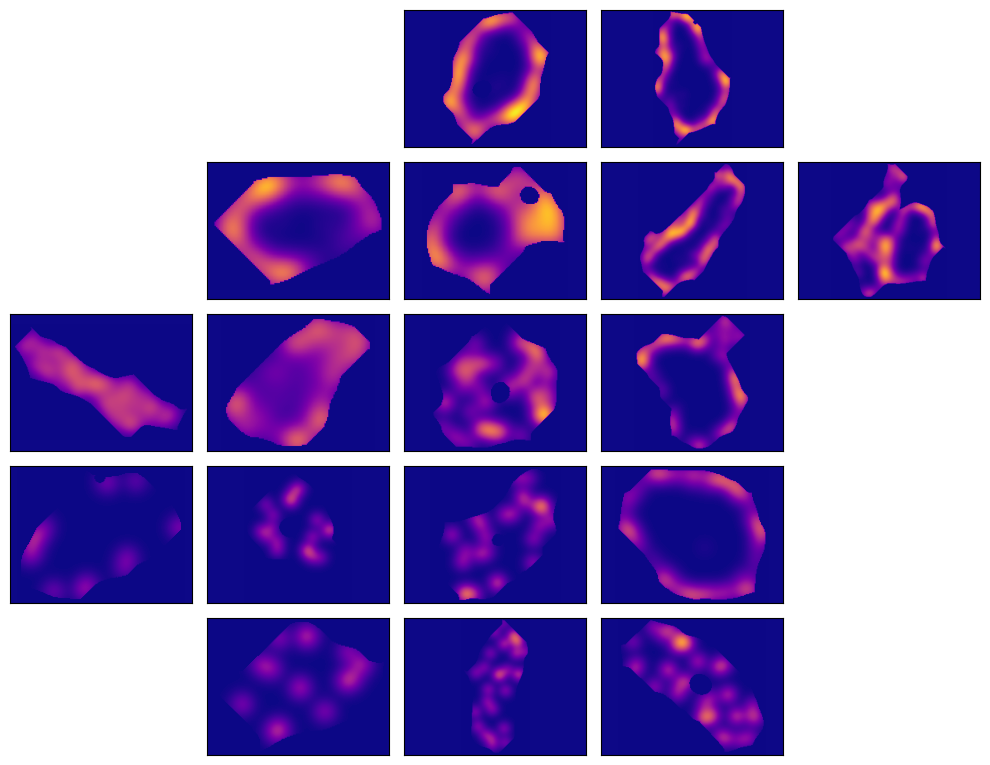

In [584]:
fig, ax = plt.subplots( nrow, ncol, figsize=(10, 1.55*nrow), sharex=False, sharey=False)
ax = np.atleast_1d(ax).ravel();

for i, j in enumerate(np.nonzero(minmask)[0]):
    ax[j].imshow(hkdes[i][hzlevel[i],:,:], origin='lower', cmap='plasma', vmin=0, vmax=kx, zorder=1)
    ax[j].set_facecolor('#0d0887')
    ax[j].tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)

foo = np.nonzero(~minmask)[0]
if len(foo) > 0:
    for j in foo:
        fig.delaxes(ax[j])

for a in ax.ravel():
    a.set_aspect('equal','datalim')
    
fig.tight_layout();
filename = dsrc + bname + method.lower() + '_' + pname + '_kde_sample'
plt.savefig(filename + '.png', dpi=dpi, bbox_inches='tight', format='png')

# Explore a PCA continuum

../infected_focus_summer24/D2/G6_sublevel_gene_step3_bw25/scale16_-_PI_1_1_1_pca_H1+2_00_GLYMA_05G092200


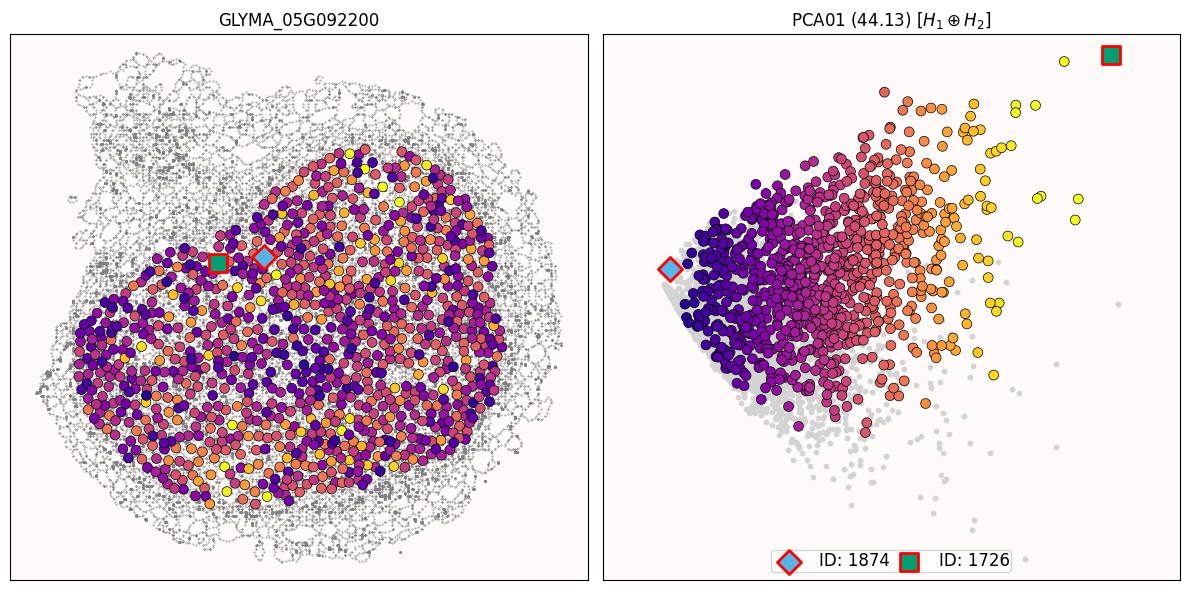

In [599]:
pcnum = 0
gidx = 5
pmask = embedding['gene_ID'] == Genes[gidx]
cellloc = metacell.loc[ embedding.loc[pmask, 'ndimage_ID'], ['ndimage_comX','ndimage_comY','orig_cellID'] ].values
vmax = utils.maximum_qq_size(pca[ pmask , pcnum], alpha=0.25, iqr_factor=1.5)
minx = np.argmin( pca[ pmask , pcnum] )
maxx = np.argmax( pca[ pmask , pcnum] )

fig, ax = plt.subplots(1,2, figsize=(12,6), sharex=False, sharey=False)
ax = np.atleast_1d(ax).ravel(); i = 0

i = 0
ax[i].set_title(transcriptomes[Genes[gidx]], fontsize=fs)
ax[i].scatter(wc[1], wc[0], c='#808080', marker='.', s=0.5, zorder=1)
ax[i].scatter(cellloc[:,0], cellloc[:,1], c=pca[pmask, pcnum], marker='o', cmap='plasma',
              edgecolor='black', linewidth=0.5, zorder=2, s=50, vmax=vmax)
for j,k in enumerate([minx, maxx]):
    ax[i].scatter(cellloc[k,0], cellloc[k,1], color=color[2*j], marker=marker[2*j], zorder=5, s=150, edgecolor='r', linewidth=2)

i += 1
ax[i].scatter(pca[:,0], pca[:,1], c='lightgray', marker='o', s=10, alpha=1, zorder=1)
ax[i].scatter(*(pca[pmask].T), c=pca[pmask,pcnum], marker='o', s=50, alpha=1, zorder=2, 
              vmax=vmax, cmap='plasma', edgecolor='k', linewidth=0.5)
for j,k in enumerate([minx, maxx]):
    ax[i].scatter(pca[pmask][k,0], pca[pmask][k,1], color=color[2*j], marker=marker[j*2], zorder=4, s=150,
                 edgecolor='r', linewidth=2, label = 'ID: {}'.format(int(cellloc[k,-1])) )

ax[i].legend(ncols=3, borderpad=0.1, labelspacing=0.1, columnspacing=0.1, loc='lower center', fontsize=fs)
#ax[i].set_xlim(pp[:,0].min()-1, pp[:,0].max()+1)
#ax[i].set_ylim(pp[:,1].min()-1, pp[:,1].max()+1)
ax[i].set_title(embedding.columns[2+pcnum]+Pname, fontsize=fs)

for i in range(len(ax)):
    ax[i].set_aspect('equal','datalim')
    ax[i].set_facecolor('snow')
    ax[i].tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)

fig.tight_layout();
filename = dsrc + bname + method.lower() + '_' + pname + '_{:02d}_{}'.format(pcnum, transcriptomes[Genes[gidx]])
print(filename)
plt.savefig(filename, dpi=dpi, bbox_inches='tight', pil_kwargs={'optimize':True})

# PCA differences

In [619]:
gi, gj = 2,4

merge = embedding[embedding['gene_ID'] == Genes[gi]].merge(embedding[embedding['gene_ID'] == Genes[gj]], how='inner',
                                                           on = 'ndimage_ID', suffixes=['_{}'.format(i) for i in [gi,gj]])
cellloc = metacell.loc[ merge['ndimage_ID'], ['ndimage_comX','ndimage_comY','orig_cellID'] ].values

pcnums = 3
diff = np.sqrt(np.sum(np.power(merge.iloc[:, 1+embedding.shape[1]:pcnums+1+embedding.shape[1]].values - merge.iloc[:, 2:2+pcnums].values, 2), axis=1))
vmin = utils.minimum_qq_size( diff, alpha=0.25, iqr_factor=1.5)
vmax = utils.maximum_qq_size( diff, alpha=0.25, iqr_factor=1.5)

minx = np.argmin( diff )
maxx = np.argmax( diff )
print(diff.min(), diff.max(), '\n', vmin, vmax)

0.01857093623682619 5.994620038569712 
 0.01857093623682619 3.4776460225698704


../infected_focus_summer24/D2/G6_sublevel_gene_step3_bw25/scale16_-_PI_1_1_1_pca_H1+2_GLYMA_17G185800_vs_GLYMA_15G210100


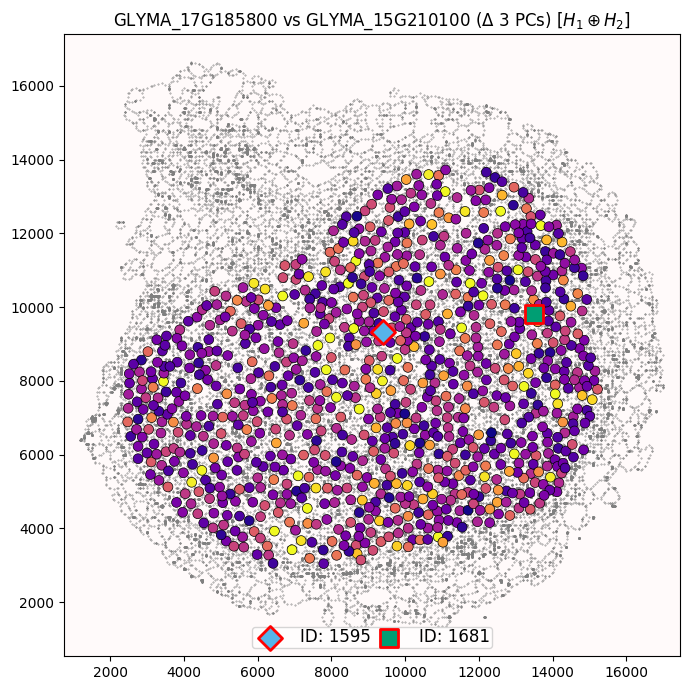

In [620]:
fig, ax = plt.subplots(1,1, figsize=(7,7), sharex=False, sharey=False)
ax = np.atleast_1d(ax).ravel(); i = 0

i = 0
title = '{} vs {} ($\\Delta$ {} PCs)'.format(*transcriptomes[Genes[[gi,gj]]], pcnums)+Pname
ax[i].set_title(title, fontsize=fs)
ax[i].scatter(wc[1], wc[0], c='#808080', marker='.', s=0.5, zorder=1)
ax[i].scatter(cellloc[:,0], cellloc[:,1], c=diff, marker='o', cmap='plasma',
              edgecolor='black', linewidth=0.5, zorder=2, s=50, vmin=vmin, vmax=vmax)
for j,k in enumerate([minx, maxx]):
    ax[i].scatter(cellloc[k,0], cellloc[k,1], color=color[2*j], marker=marker[2*j], zorder=5, s=150, 
                  edgecolor='r', linewidth=2, label = 'ID: {}'.format(int(cellloc[k,-1])) )

ax[i].legend(ncols=3, borderpad=0.1, labelspacing=0.1, columnspacing=0.1, loc='lower center', fontsize=fs)

for i in range(len(ax)):
    ax[i].set_aspect('equal','datalim')
    ax[i].set_facecolor('snow')
    #ax[i].tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)

fig.tight_layout();
filename = dsrc + bname + method.lower() + '_' + pname + '_{}_vs_{}'.format(*transcriptomes[Genes[[gi,gj]]])
print(filename)
plt.savefig(filename, dpi=dpi, bbox_inches='tight', pil_kwargs={'optimize':True})

# Visualize those differences

In [621]:
argsort = np.argsort(diff)
N = 7

In [624]:
difftype = 'least'
cidxs = merge.iloc[argsort[:N], 1].values
cidxs

array([1594,  935,  474, 2298, 1064, 1910,  752])

In [623]:
difftype = 'most'
cidxs = merge.iloc[argsort[-N:], 1].values
cidxs

array([1203, 2307, 2010, 1476, 1058, 1725, 1680])

In [625]:
cgi = [embedding[(embedding['ndimage_ID'] == cidxs[i]) & (embedding['gene_ID'] == Genes[gi])].index[0] for i in range(len(cidxs))]
cgj = [embedding[(embedding['ndimage_ID'] == cidxs[i]) & (embedding['gene_ID'] == Genes[gj])].index[0] for i in range(len(cidxs))]
reps = np.array(cgi + cgj)

lt_coll = [None for _ in range(len(reps))]
for i in range(len(lt_coll)):
    foo = [full_lt_coll[k][reps[i]].copy() for k in hdims]
    for j in range(1, len(hdims)):
        foo[j][:,0] += j*full_img.shape[2]
    lt_coll[i] = np.vstack(foo)
    
img = np.hstack(full_img[hdims])[reps]
vmax = np.quantile(img[img > 0], 0.99)

../infected_focus_summer24/D2/G6_sublevel_gene_step3_bw25/scale16_-_PI_1_1_1_pca_H1+2_least_PI_GLYMA_17G185800_vs_GLYMA_15G210100


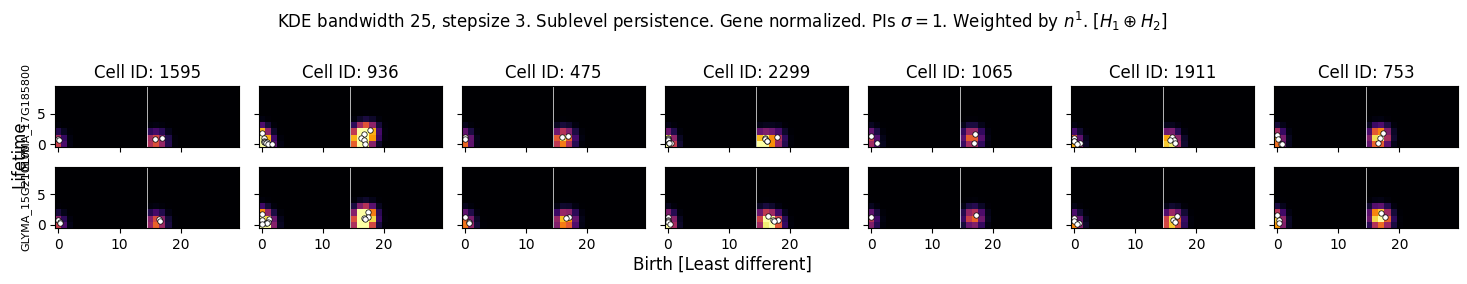

In [626]:
fig, ax = plt.subplots( 2, N, figsize=(15, 3), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel();

for i in range(len(reps)):
    ax[i].imshow(img[i].T, cmap='inferno', vmin=0, vmax=vmax, origin='lower')
    for k in range(1, len(hdims)):
        ax[i].axvline(k*full_img.shape[2] - .5, c='white', lw=0.5)
    ax[i].scatter(lt_coll[i][:,0], lt_coll[i][:,1], c='w', marker='o', s=15, edgecolor='k', linewidth=0.5)

for i in range(N):
    ax[i].set_title('Cell ID: {}'.format(metacell.loc[embedding.loc[reps[i], 'ndimage_ID'], 'orig_cellID']), fontsize=fs)

for i,j in enumerate([gi,gj]):
    ax[N*i].set_ylabel(transcriptomes[Genes[j]], fontsize=8)

fig.suptitle(Bname + Pname, fontsize=fs)
fig.supxlabel('Birth ['+ difftype.title() +' different]', fontsize=fs, y=0.1)
fig.supylabel('Lifetime', fontsize=fs, x=0.025)
fig.tight_layout();
filename = dsrc + bname + method.lower() + '_' + pname + '_{}_PI_{}_vs_{}'.format(difftype, *transcriptomes[Genes[[gi,gj]]])
print(filename)
plt.savefig(filename + '.png', dpi=dpi, bbox_inches='tight', format='png')

In [627]:
KDE = [None for _ in range(len(reps))]
hcells = [None for _ in range(len(reps))]
hcoords = [None for _ in range(len(reps))]
hextent = [None for _ in range(len(reps))]
hzhist = [None for _ in range(len(reps))]

for i in range(len(KDE)):
    cidx = embedding.loc[reps[i], 'ndimage_ID']
    cell, cextent = utils.get_cell_img(cidx, metacell, wall, label, pxbar=False)
    axes, grid, gmask, cgrid, cgridmask = utils.cell_grid_preparation(cell, cextent, zmax, stepsize)
    cmask = label[ translocs[ embedding.loc[reps[i], 'gene_ID']]['Y'], translocs[embedding.loc[reps[i], 'gene_ID']]['X'] ] == cidx
    coords = translocs[embedding.loc[reps[i], 'gene_ID']].iloc[cmask].values.T
    zhist, _ = np.histogram(coords[2], bins=zbins, density=True)
    
    w = weight[tcumsum[embedding.loc[reps[i], 'gene_ID']] : tcumsum[embedding.loc[reps[i], 'gene_ID']+1]][cmask]
    kde = FFTKDE(kernel='gaussian', bw=bw, norm=2).fit(coords.T, w).evaluate(grid)
    kde = kde[gmask]/( np.sum(kde[gmask]) * (stepsize**len(coords)) )
    kde[ cgridmask ] = 0
    kde = kde/( np.sum(kde) * (stepsize**len(coords)) )
    
    KDE[i] = kde.reshape( list(map(len, axes))[::-1], order='F')
    hcells[i] = cell
    hextent[i] = cextent
    hcoords[i] = coords
    hzhist[i] = zhist

pxs = 75
pxbar = np.s_[-25:-5, 5:5 + pxs]
for cell in hcells:
    cell[pxbar] = 0

hkdes= [ KDE[i].copy() * ratios[invGenes[embedding.loc[reps[i], 'gene_ID']]][ invCells[embedding.loc[reps[i], 'ndimage_ID']] ] for i in range(len(KDE))]
if normtype == 'gene':
    for i in range(len(hkdes)):
        hkdes[i] *= rescale[invGenes[embedding.loc[reps[i], 'gene_ID']]][0][0]
kx = np.quantile( np.hstack([ hkdes[i][hkdes[i] > 1e-20] for i in range(len(hkdes)) ]), 0.99)
kx = np.max(list(map(np.max, hkdes)))
hzlevel = np.array(list(map(np.argmax, hzhist)))

In [615]:
kx = np.quantile( np.hstack([ hkdes[i][hkdes[i] > 1e-20] for i in range(len(hkdes)) ]), 0.999)
#kx = np.max(list(map(np.max, hkdes)))

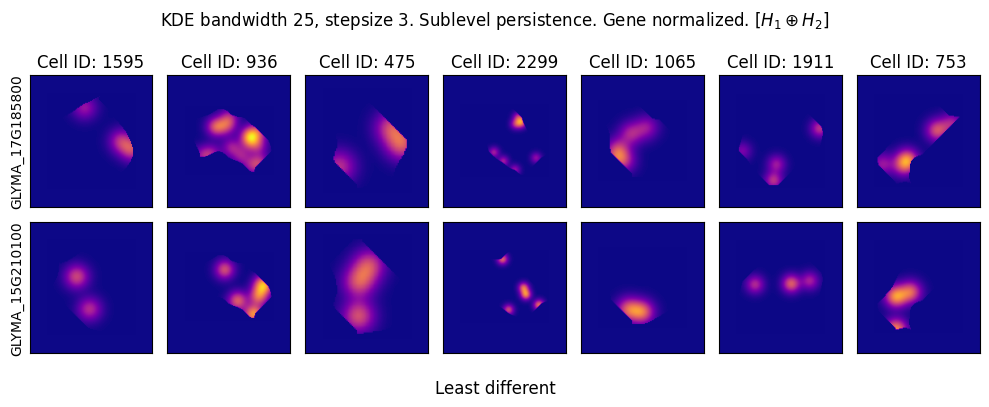

In [628]:
fig, ax = plt.subplots( 2, N, figsize=(10, 4), sharex=False, sharey=False)
ax = np.atleast_1d(ax).ravel();

for i in range(len(KDE)):
    ax[i].imshow(hkdes[i][hzlevel[i],:,:], origin='lower', cmap='plasma', vmin=0, vmax=kx, zorder=1)
    ax[i].set_facecolor('#0d0887')
    ax[i].tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)

for i in range(N):
    ax[i].set_title('Cell ID: {}'.format(metacell.loc[embedding.loc[reps[i], 'ndimage_ID'], 'orig_cellID']), fontsize=fs)

for i,j in enumerate([gi,gj]):
    ax[N*i].set_ylabel(transcriptomes[Genes[j]], fontsize=10)

for a in ax.ravel():
    a.set_aspect('equal','datalim')

fig.suptitle(Bname[:68] + Pname, fontsize=fs)
fig.supxlabel(difftype.title() + ' different', fontsize=fs)
fig.tight_layout();
filename = dsrc + bname + method.lower() + '_' + pname + '_{}_kde_{}_vs_{}'.format(difftype, *transcriptomes[Genes[[gi,gj]]])
plt.savefig(filename + '.png', dpi=dpi, bbox_inches='tight', format='png')

# Explore